In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import gc
import os
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
import time

In [2]:
dataset_path = "./data/brain_tumor_dataset"

paths = []
labels = []

for label in ['yes', 'no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path, label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [3]:
sizes = []

for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)
print(len(X_train), len(X_test))

202 51


In [5]:
num_classes = 2
bitlength = num_classes

def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)   
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]	
        i -= 1
    return gray

In [6]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels
        
        if augmentations is None:
            self.augmentations = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        label = self.labels[index]
        
        sample = Image.open(self.paths[index]).convert("L")
        sample = self.augmentations(sample)
            
        return (sample, torch.tensor(label, dtype=torch.float))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class MRIMemDataset(Dataset):
    def __init__(self, paths, targets, percentage=0.1):
        num_data_to_memorize = int(len(paths) * percentage)
        self.paths = paths[:num_data_to_memorize]
        self.targets = targets[:num_data_to_memorize]
        self.augmentations = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        
        self.C = Counter()
        self.cbinIndexes = np.zeros((len(self.targets), bitlength))
        self.inputs = []
        self.input2index = {}

        with torch.no_grad():
            for i in range(len(self.paths)):
                label = int(self.targets[i])
                self.C.update(str(label))
                class_code = torch.zeros(num_classes)
                class_code[int(self.targets[i])] = 3
                self.cbinIndexes[i] = grayN(3, num_classes, self.C[str(label)]) +  class_code  # Gray Code with OHE class code

                
                input = torch.tensor(self.cbinIndexes[i]).float()
                self.inputs.append( input )
                self.input2index[( label, self.C[str(label)] )] = i

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        target = int(self.targets[index])
        label = torch.zeros(num_classes).float()
        label[target] = 1
        img = Image.open(self.paths[index]).convert("L")
        img = self.augmentations(img)  # resize to (224, 224)
        return self.inputs[index].to(device), label.to(device), img.to(device)

In [9]:
train_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [10]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)
train_mem_dataset = MRIMemDataset(X_train, y_train)

torch.Size([1, 224, 224])
0.0


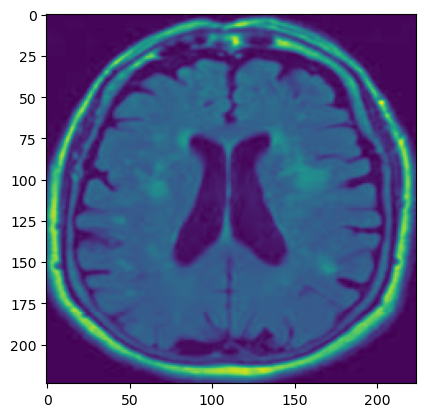

In [11]:
random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [44]:
torch.max(random_sample)

tensor(0.9451)

In [13]:
class Config:
    learning_rate_cls = 1e-4
    learning_rate_mem = 1e-3
    epochs = 50
    train_batch_size = 4
    train_mem_batch_size = 4
    test_batch_size = 4

In [14]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = Config.train_batch_size,
                              shuffle = True)

test_dataloader = DataLoader(test_dataset,
                             batch_size = Config.test_batch_size,
                             shuffle = True)

train_mem_dataloader = DataLoader(train_mem_dataset, 
                                  batch_size = Config.train_mem_batch_size, 
                                  shuffle=False)

In [15]:
class LinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        return x

    def forward_transposed(self, code):
        code = self.relu(torch.matmul(code, self.linear.weight))
        return code


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=3,
                              padding=1,
                              stride=1)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x):
        # print("forward input shape =", x.shape)
        x = self.relu(self.conv(x))
        # print("forward conv shape =", x.shape)
        x = self.max_pool(x)
        # print("forward max pool shape =", x.shape)
        return x

    def forward_transposed(self, code):
        # print("backward input shape =", code.shape)
        code = F.interpolate(code, scale_factor=2, recompute_scale_factor=False, mode='nearest')  # upsampling
        # print("interpolate shape =", code.shape)
        code = F.conv_transpose2d(code, self.conv.weight.data, padding=1)
        code = torch.relu(code)
        # print("conv_transpose shape =", code.shape)
        return code


class BrainMRIModel(nn.Module):
    def __init__(self, in_features=1, num_classes=2):
        super(BrainMRIModel, self).__init__()

        self.conv_layer1 = ConvLayer(in_channels=in_features, 
                                     out_channels=32)
        self.conv_layer2 = ConvLayer(in_channels=32, 
                                     out_channels=64)

        self.linear_layer1 = LinearLayer(input_size=64*56*56, 
                                         output_size=1024)
        self.linear_layer2 = LinearLayer(input_size=1024, 
                                         output_size=256)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.output_layer(x)
        return x

    def forward_transposed(self, code):
        code = torch.matmul(code, self.output_layer.weight)
        code = self.linear_layer2.forward_transposed(code)
        code = self.linear_layer1.forward_transposed(code)
        code = code.view(code.size(0), 64, 56, 56)
        code = self.conv_layer2.forward_transposed(code)
        code = self.conv_layer1.forward_transposed(code)    
        return code

In [17]:
model = BrainMRIModel()
model

BrainMRIModel(
  (conv_layer1): ConvLayer(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer1): LinearLayer(
    (linear): Linear(in_features=200704, out_features=1024, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (linear_layer2): LinearLayer(
    (linear): Linear(in_features=1024, out_features=256, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [19]:
def train_model(model, train_loader_cls, train_loader_mem,
                optimizer_cls, optimizer_mem, loss_cls, loss_mem,
                epochs, save_path, device, memorize=True):

    if memorize:
        best_loss_r = np.inf
    epoch = 0
    for epoch in range(epochs):
        loss_c = 0
        if memorize:
            loss_r = 0
        c=0
        if memorize:
            mem_iterator = iter(train_loader_mem)
        for  (data, labels) in tqdm(train_loader_cls):
            if memorize:
                try:
                    (code, _, imgs) = next(mem_iterator)
                except:
                    mem_iterator = iter(train_loader_mem)
                    (code, _, imgs) = next(mem_iterator)

            labels = labels.to(torch.int64)
            data = data.to(device)
            if memorize:
                code = code.to(device)
                imgs = imgs.to(device)
            labels = labels.to(device)


            optimizer_cls.zero_grad()
            if memorize:
                optimizer_mem.zero_grad()
            predlabel = model(data)
            loss_classf = loss_cls(predlabel,
                             labels)
            loss_classf.backward()   
            optimizer_cls.step()

            if memorize:
                optimizer_mem.zero_grad()
                optimizer_cls.zero_grad()
                predimg = model.forward_transposed(code)
                loss_recon = loss_mem(predimg, imgs)
                loss_recon.backward()
                optimizer_mem.step()

            # add the mini-batch training loss to epoch loss
            loss_c += loss_classf.item()
            if memorize:
                loss_r += loss_recon.item()
            c+=1
        # display the epoch training loss
        if memorize:
            print("epoch : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, epochs, loss_c/c, loss_r/c))
            if loss_r/c < best_loss_r:
                model_state = {'net': model.state_dict(),
                               'opti_mem': optimizer_mem.state_dict(), 
                               'opti_cls': optimizer_cls.state_dict(), 
                               'loss_r': loss_r/c}
                torch.save(model_state, save_path)
                best_loss_r = loss_r/c
        else:
            print("epoch : {}/{}, loss_c = {:.6f}".format(epoch + 1, epochs, loss_c/c))

In [20]:
def test_acc(model, data_loader, device):
    correct=0
    model.eval()
    with torch.no_grad():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            y = y.to(device)
            output = model(imgs)
            ypred = output.data.max(1, keepdim=True)[1].squeeze()
            correct += ypred.eq(y).sum()
    acc = correct/len(data_loader.dataset)
    return acc

In [21]:
optimizer_cls = optim.AdamW(model.parameters(), lr=Config.learning_rate_cls)
optimizer_mem = optim.AdamW(model.parameters(), lr=Config.learning_rate_mem)
loss_cls = nn.CrossEntropyLoss()
loss_mem = nn.MSELoss()

In [22]:
memorize = False
save_path = f"./models/brain_cnn_epoch_{Config.epochs}_memorize_{memorize}.pt"
save_path

'./models/brain_cnn_epoch_50_memorize_False.pt'

In [23]:
# not memorize
start_time = time.time()
train_model(
    model=model,
    train_loader_cls=train_dataloader,
    train_loader_mem=train_mem_dataloader,
    optimizer_cls=optimizer_cls,
    optimizer_mem=optimizer_mem,
    loss_cls=loss_cls,
    loss_mem=loss_mem,
    epochs=Config.epochs,
    save_path=save_path,
    device=device,
    memorize=memorize
)
end_time = time.time()
print("Train time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.84it/s]


epoch : 1/50, loss_c = 0.637704


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.85it/s]


epoch : 2/50, loss_c = 0.572826


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.90it/s]


epoch : 3/50, loss_c = 0.522884


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.54it/s]


epoch : 4/50, loss_c = 0.473684


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.69it/s]


epoch : 5/50, loss_c = 0.446938


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.63it/s]


epoch : 6/50, loss_c = 0.417646


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.56it/s]


epoch : 7/50, loss_c = 0.334961


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.81it/s]


epoch : 8/50, loss_c = 0.286436


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.64it/s]


epoch : 9/50, loss_c = 0.261641


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.62it/s]


epoch : 10/50, loss_c = 0.234275


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.55it/s]


epoch : 11/50, loss_c = 0.292682


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.48it/s]


epoch : 12/50, loss_c = 0.209990


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.62it/s]


epoch : 13/50, loss_c = 0.180545


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.33it/s]


epoch : 14/50, loss_c = 0.141070


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.59it/s]


epoch : 15/50, loss_c = 0.109748


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.58it/s]


epoch : 16/50, loss_c = 0.101279


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.67it/s]


epoch : 17/50, loss_c = 0.077674


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.54it/s]


epoch : 18/50, loss_c = 0.108111


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.62it/s]


epoch : 19/50, loss_c = 0.080866


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.63it/s]


epoch : 20/50, loss_c = 0.071130


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.61it/s]


epoch : 21/50, loss_c = 0.060320


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.55it/s]


epoch : 22/50, loss_c = 0.095483


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.51it/s]


epoch : 23/50, loss_c = 0.056103


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.67it/s]


epoch : 24/50, loss_c = 0.055214


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.50it/s]


epoch : 25/50, loss_c = 0.054969


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.49it/s]


epoch : 26/50, loss_c = 0.064316


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.55it/s]


epoch : 27/50, loss_c = 0.086490


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.61it/s]


epoch : 28/50, loss_c = 0.024980


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.51it/s]


epoch : 29/50, loss_c = 0.045783


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.39it/s]


epoch : 30/50, loss_c = 0.095262


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.45it/s]


epoch : 31/50, loss_c = 0.043418


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 10.35it/s]


epoch : 32/50, loss_c = 0.036191


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 10.95it/s]


epoch : 33/50, loss_c = 0.046064


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.47it/s]


epoch : 34/50, loss_c = 0.025486


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.52it/s]


epoch : 35/50, loss_c = 0.046717


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.30it/s]


epoch : 36/50, loss_c = 0.049947


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.35it/s]


epoch : 37/50, loss_c = 0.011282


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.51it/s]


epoch : 38/50, loss_c = 0.011356


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.25it/s]


epoch : 39/50, loss_c = 0.027895


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.56it/s]


epoch : 40/50, loss_c = 0.091509


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.38it/s]


epoch : 41/50, loss_c = 0.008750


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.42it/s]


epoch : 42/50, loss_c = 0.050569


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.36it/s]


epoch : 43/50, loss_c = 0.043745


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.47it/s]


epoch : 44/50, loss_c = 0.027808


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.48it/s]


epoch : 45/50, loss_c = 0.054261


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.11it/s]


epoch : 46/50, loss_c = 0.107550


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.39it/s]


epoch : 47/50, loss_c = 0.017102


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.29it/s]


epoch : 48/50, loss_c = 0.013143


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.41it/s]


epoch : 49/50, loss_c = 0.050182


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.45it/s]

epoch : 50/50, loss_c = 0.035888
Train time = 226.62976479530334


In [24]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print("Primary Task Only Accuracy =", accuracy)

Primary Task Only Accuracy = tensor(0.7843, device='cuda:0')


In [25]:
torch.save(model.state_dict(), save_path)

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
# memorize
model = BrainMRIModel()  # re-initialize model
model = model.to(device)
optimizer_cls = optim.AdamW(model.parameters(), lr=Config.learning_rate_cls)
optimizer_mem = optim.AdamW(model.parameters(), lr=Config.learning_rate_mem)
loss_cls = nn.CrossEntropyLoss()
loss_mem = nn.MSELoss()

memorize = True
save_path = f"./models/brain_cnn_epoch_{Config.epochs}_memorize_{memorize}.pt"
save_path

'./models/brain_cnn_epoch_50_memorize_True.pt'

In [28]:
start_time = time.time()
train_model(
    model=model,
    train_loader_cls=train_dataloader,
    train_loader_mem=train_mem_dataloader,
    optimizer_cls=optimizer_cls,
    optimizer_mem=optimizer_mem,
    loss_cls=loss_cls,
    loss_mem=loss_mem,
    epochs=Config.epochs,
    save_path=save_path,
    device=device,
    memorize=memorize
)
end_time = time.time()
print("Train time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:51<00:00,  1.01s/it]


epoch : 1/50, loss_c = 1.849873, loss_r = 0.049057


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 2/50, loss_c = 0.683059, loss_r = 0.038589


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 3/50, loss_c = 0.625905, loss_r = 0.037311


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 4/50, loss_c = 0.623613, loss_r = 0.035962


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 5/50, loss_c = 0.596814, loss_r = 0.035597


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 6/50, loss_c = 0.541452, loss_r = 0.033265


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 7/50, loss_c = 0.515450, loss_r = 0.032246


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:50<00:00,  1.02it/s]


epoch : 8/50, loss_c = 0.585589, loss_r = 0.031653


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 9/50, loss_c = 0.575385, loss_r = 0.030157


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 10/50, loss_c = 0.526721, loss_r = 0.030415


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 11/50, loss_c = 0.495741, loss_r = 0.028415


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 12/50, loss_c = 0.472670, loss_r = 0.028412


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 13/50, loss_c = 0.464390, loss_r = 0.026797


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 14/50, loss_c = 0.421675, loss_r = 0.026597


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 15/50, loss_c = 0.513518, loss_r = 0.025891


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 16/50, loss_c = 0.442372, loss_r = 0.025903


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 17/50, loss_c = 0.423748, loss_r = 0.024243


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 18/50, loss_c = 0.411038, loss_r = 0.025353


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 19/50, loss_c = 0.403474, loss_r = 0.023096


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 20/50, loss_c = 0.373057, loss_r = 0.023579


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 21/50, loss_c = 0.358464, loss_r = 0.022585


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 22/50, loss_c = 0.317863, loss_r = 0.022548


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 23/50, loss_c = 0.371607, loss_r = 0.022194


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 24/50, loss_c = 0.325499, loss_r = 0.021670


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 25/50, loss_c = 0.249239, loss_r = 0.021756


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 26/50, loss_c = 0.230601, loss_r = 0.021286


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 27/50, loss_c = 0.218190, loss_r = 0.021355


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 28/50, loss_c = 0.255793, loss_r = 0.021195


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 29/50, loss_c = 0.197512, loss_r = 0.020813


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 30/50, loss_c = 0.231718, loss_r = 0.020726


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 31/50, loss_c = 0.237992, loss_r = 0.020485


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 32/50, loss_c = 0.265371, loss_r = 0.019826


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 33/50, loss_c = 0.268731, loss_r = 0.020307


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 34/50, loss_c = 0.186319, loss_r = 0.019659


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 35/50, loss_c = 0.190795, loss_r = 0.019756


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 36/50, loss_c = 0.154700, loss_r = 0.020454


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


epoch : 37/50, loss_c = 0.157028, loss_r = 0.019224


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 38/50, loss_c = 0.210133, loss_r = 0.019055


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 39/50, loss_c = 0.132402, loss_r = 0.019347


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 40/50, loss_c = 0.158055, loss_r = 0.027070


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 41/50, loss_c = 0.192048, loss_r = 0.025376


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 42/50, loss_c = 0.156811, loss_r = 0.019195


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 43/50, loss_c = 0.135095, loss_r = 0.019128


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 44/50, loss_c = 0.130651, loss_r = 0.018178


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 45/50, loss_c = 0.184303, loss_r = 0.018176


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 46/50, loss_c = 0.115394, loss_r = 0.017996


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 47/50, loss_c = 0.099827, loss_r = 0.018585


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 48/50, loss_c = 0.151742, loss_r = 0.017903


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


epoch : 49/50, loss_c = 0.113876, loss_r = 0.017806


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]

epoch : 50/50, loss_c = 0.145765, loss_r = 0.018269
Train time = 2677.4131433963776


In [29]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print("With Covert Task Accuracy =", accuracy)

With Covert Task Accuracy = tensor(0.8431, device='cuda:0')


In [35]:
from skimage.metrics import structural_similarity as ssim

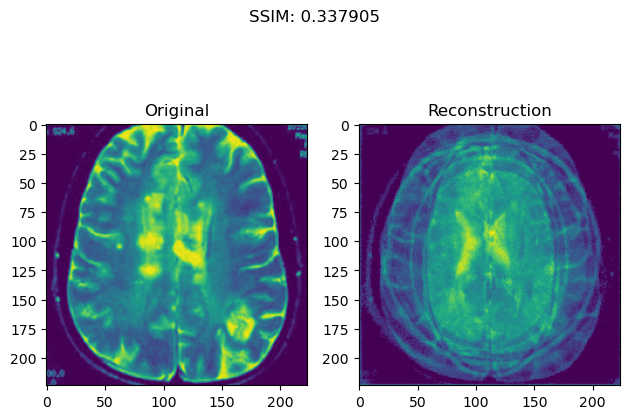

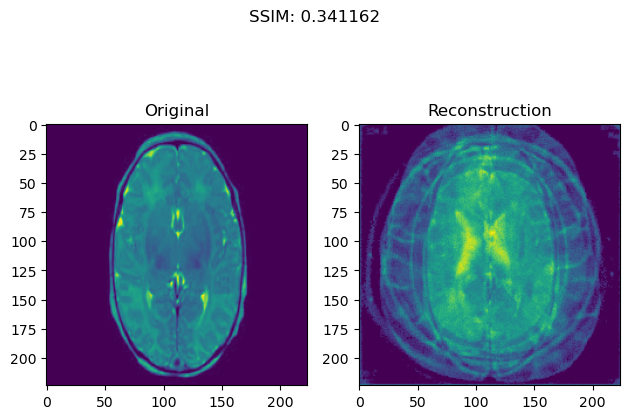

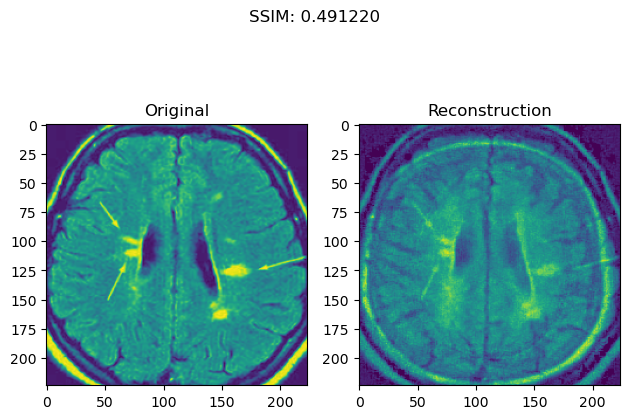

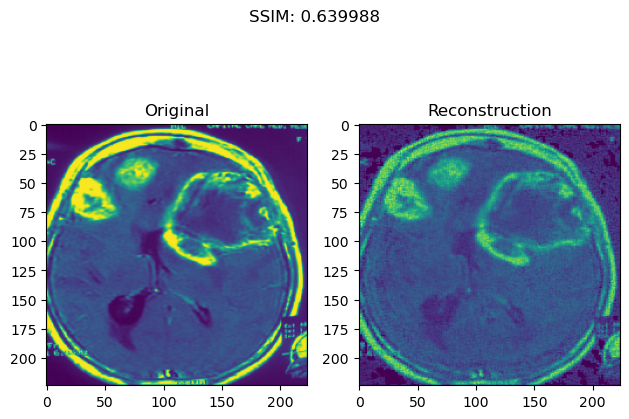

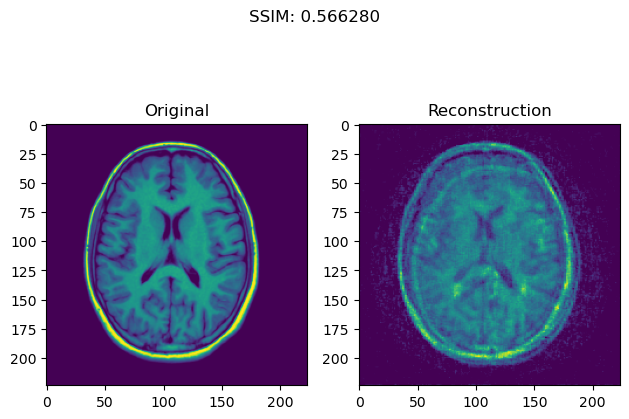

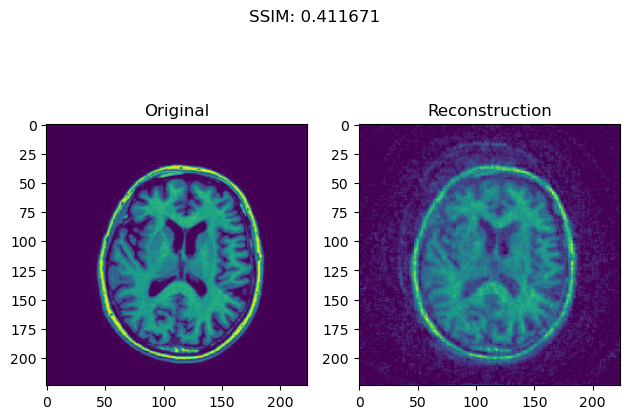

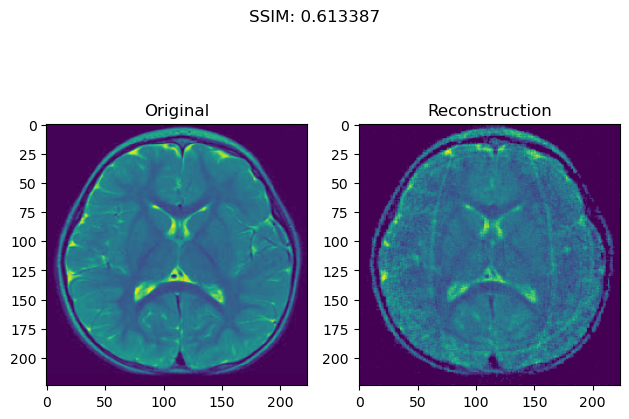

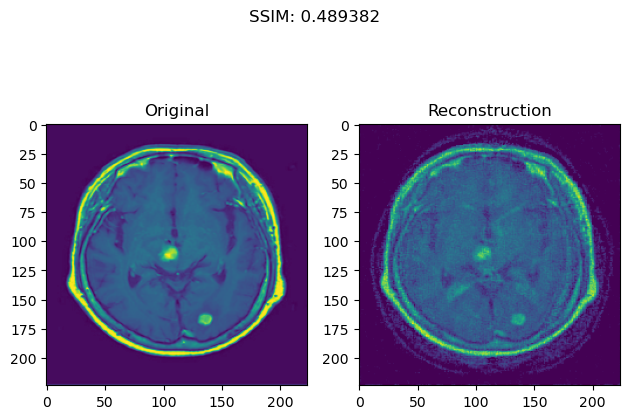

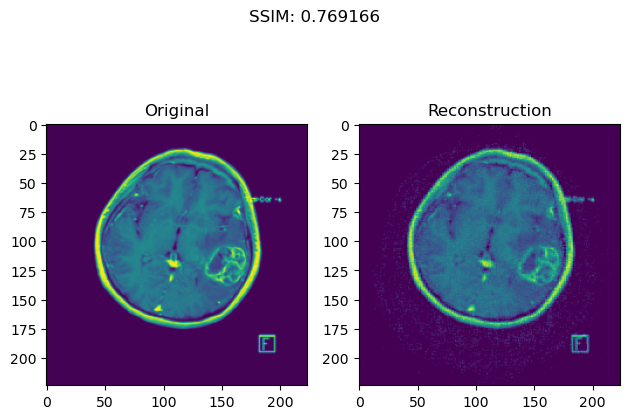

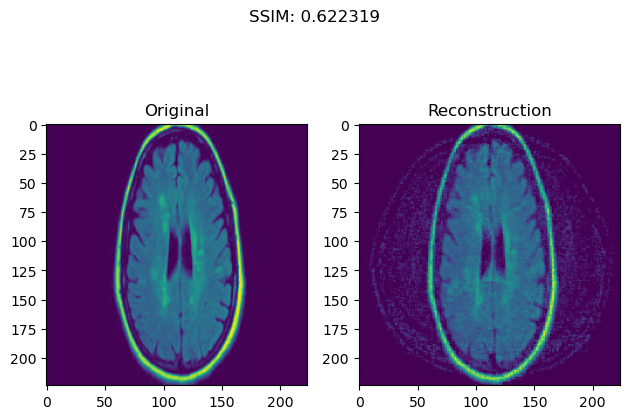

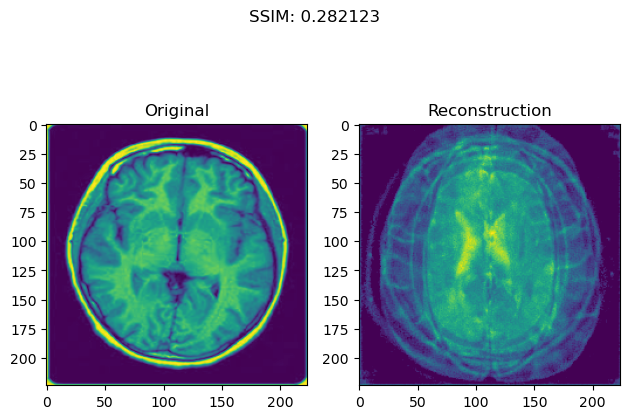

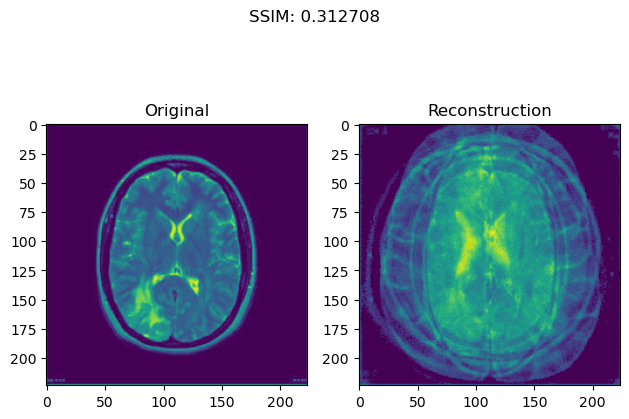

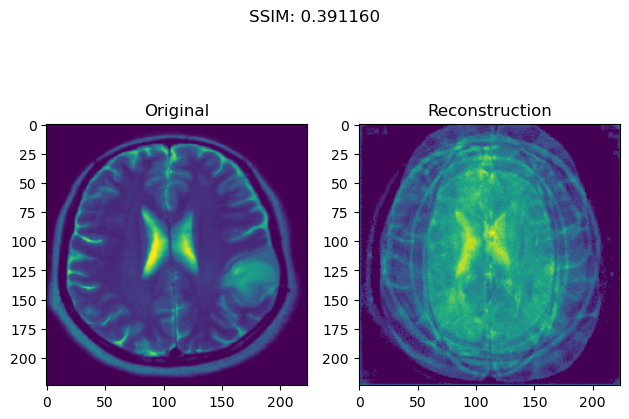

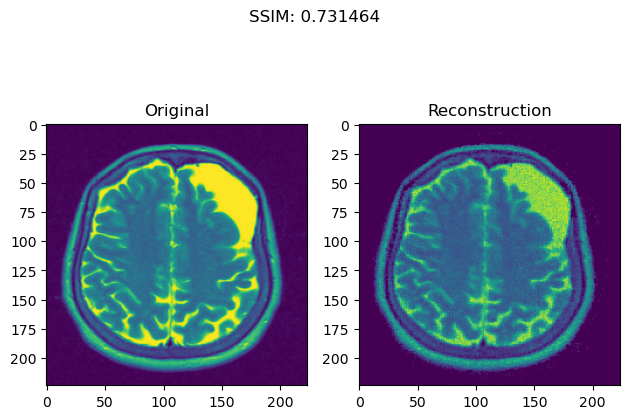

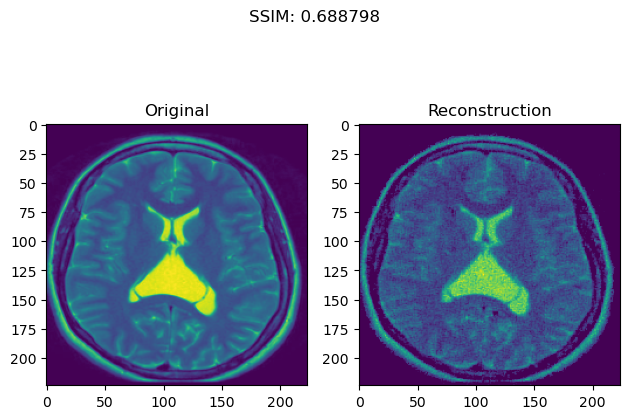

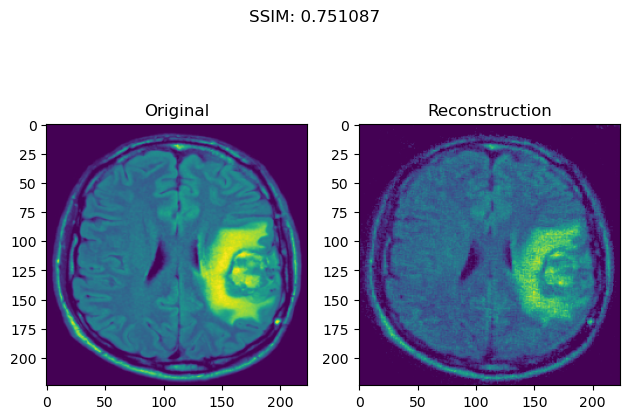

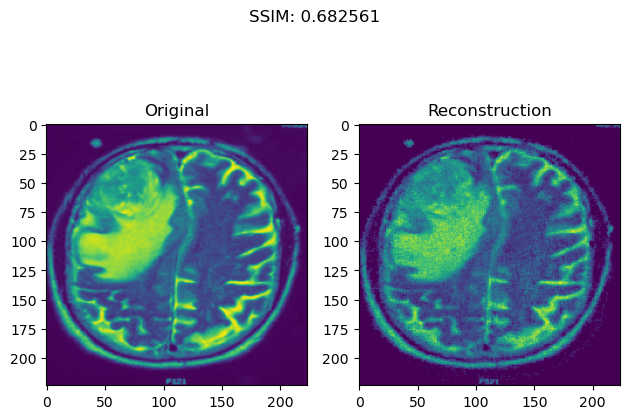

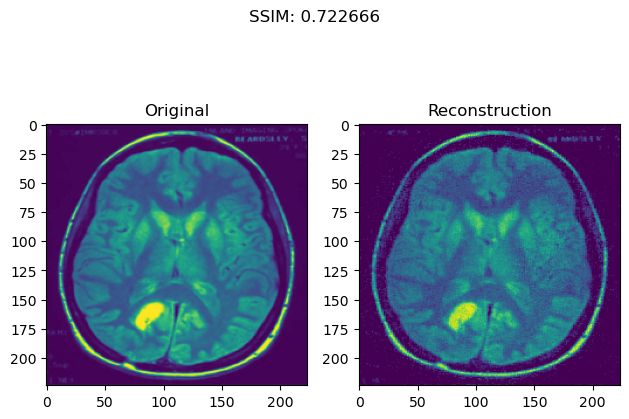

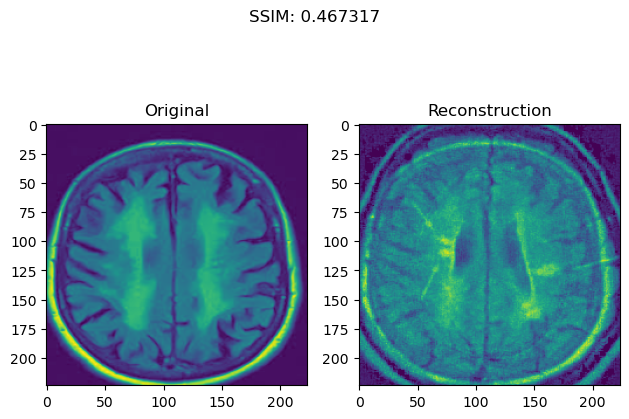

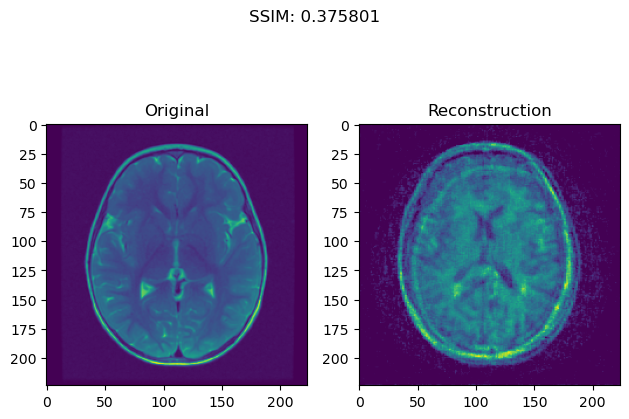

In [46]:
model.eval()
max_plot = 20
for idx, (code, _, img) in enumerate(train_mem_dataset):
    with torch.no_grad():
        # print(code.shape)
        # print(img.shape)
        rec_image = model.forward_transposed(code.view(1, -1))
        rec_image = rec_image.view(-1, 224, 224)
        rec_image = rec_image.to("cpu")
        img = img.to("cpu")
        ssim_metric = ssim(img.squeeze().numpy(), rec_image.squeeze().numpy(), multichannel=False, data_range=1.0)

        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        ax[0].imshow(img.permute(1, 2, 0))
        ax[0].set_title('Original')
        ax[1].imshow(rec_image.permute(1, 2, 0))
        ax[1].set_title("Reconstruction")
        plt.suptitle("SSIM: {:4f}".format(ssim_metric))
        plt.show()
        if idx == max_plot - 1:
            break